In [1]:
# we won't cover how to generate predictors here;
# just import the functions that do it for us
from context import mathlang
from mathlang import predictor

# pointers to data directories
from mathlang import config
            
import pathlib            # file i/o
import mne                # MEG data processing routines 
import eelbrain as eel    # boosting routines     
import scipy.signal       
import numpy as np       
import matplotlib.pyplot as plt  

In [2]:
mne.set_log_level('ERROR') 
eel.configure(n_workers=8) # use 8 cores

In [3]:
class EstimateTRF:
    def __init__(self, subject="R2581"):
        self.subject = subject
        
        datadir = pathlib.Path.cwd() / "../../../data/gamma_trf/"
        self.outpath = pathlib.Path.cwd() / "../../../outputs/gamma_trfs/"
        
        # pointer to fsaverage subject
        self.mri_dir = pathlib.Path.cwd() / datadir / "subject_data/fsaverage/mri/"
        
        # pointer to MEG data for current subject
        subdatadir = pathlib.Path.cwd() / datadir / "subject_data/"
        self.subdata, = list(subdatadir.glob(f"{subject}*"))
        
        # parcellation file for 7mm-voxel volume source space
        self.parcfile = pathlib.Path.cwd() / datadir / "parc_sym-aparc+aseg-nowhite-vol-7-cortex_brainstem_full.pkl"
        
        # cortex regions of interest
        ctxll = ['inferiortemporal', 'middletemporal',
                       'superiortemporal','bankssts', 'transversetemporal']
        subctxll = []
        self.ROI = ['ctx-lh-'+l for l in ctxll] + ['ctx-rh-'+l for l in ctxll] + \
                    subctxll + ['Left-'+l for l in subctxll] + ['Right-'+l for l in subctxll]
        
        # boost from -41 ms to 210 ms
        self.boostingFraction = [-0.041,0.21]
    
    
    ##################################################################################################################
    # Load data
    ##################################################################################################################
    def load_data(self):
        print("loading data")
        # load forward solution, epochs, and empty room covariance
        fwd_sol_file, = (self.subdata / 'sourcespace').glob("*vol-7*fwd*.fif")
        epo_file, = (self.subdata).glob("*single*epo*.fif")
        cov_file, = (self.subdata / 'sourcespace').glob("*single*cov*.fif")
        epochs = mne.read_epochs(epo_file)
        
        self.fwd = mne.read_forward_solution(fwd_sol_file)
        self.cov = mne.read_cov(cov_file)
        
        
        # 20-30 is James Equations trials for this subject
        epochs = epochs[20:30] 
        
        # ensure 0-18 seconds long
        epochs.crop(0, 18, False)
        
        self.epochs = epochs

    
    ##################################################################################################################
    # STC estimation
    ##################################################################################################################
    def make_inverse_MNE(self):
        print("estimating STCs")
        inv = mne.minimum_norm.make_inverse_operator(self.epochs.info, self.fwd, self.cov, loose=1)
        
        # run MEG sensor data through inverse operator to obtain source time courses
        self.stc = mne.minimum_norm.apply_inverse_epochs(self.epochs, inv, lambda2=0.111, pick_ori='vector')

        
    ##################################################################################################################
    # Parcellation
    ##################################################################################################################
    def parcellate(self):
        print("applying parcellation")
        # wrap stcs in an eelbrain NDVar; boosting routine takes NDVars as inputs
        snd = eel.load.fiff.stc_ndvar(self.stc, self.subject, 
                                      'vol-7-cortex_brainstem_full', subjects_dir=self.mri_dir)
        
        # NDVars make it easy to parcellate
        snd.source.parc = eel.load.unpickle(self.parcfile)
        
        # voxels of interest
        voilist = [s for s in self.ROI if s in snd.source.parc]
        
        # drop stcs not within the voxels of interest
        snd = snd.sub(source=voilist)
        self.snd_aud = eel.concatenate([snd[i:i+1] for i in range(len(self.epochs))], dim='time')
    
    ##################################################################################################################
    # Generate predictors
    ##################################################################################################################
    def generate_predictors(self):
        print("generating predictors")
        ds = eel.Dataset()
        ds['source'] = eel.resample(self.snd_aud, 500)
        ds['envelope'] = eel.resample(predictor.get_james_math_envelope(single_speaker=True), 500)
        self.ds = ds

    
    ##################################################################################################################
    # Boosting
    ##################################################################################################################
    def boost(self):
        print("boosting")
        boostedresult = predictor.boostWrap(self.ds, ["envelope"], self.outpath, self.subject, 
                                            f'vol-7-cortex-DEMO', self.boostingFraction, 0.004, 
                                            4, 'source', False)
        self.boostedresult = boostedresult
        return boostedresult


# Set up TRF estimation

#### Load data $\rightarrow$ preprocess stimulus and MEG data $\rightarrow$ generate predictors $\rightarrow$ boost TRFs

In [4]:
# instantiate class
TRF = EstimateTRF()

# load data
TRF.load_data()

# preprocess MEG data + stimulus
TRF.make_inverse_MNE()
TRF.parcellate()

# generate predictors
TRF.generate_predictors()

loading data
estimating STCs
applying parcellation
generating predictors


In [8]:
TRF.boost()

boosting


Fitting models:   0%|          | 0/4752 [00:00<?, ?it/s]

(<boosting source ~ envelope, -0.041 - 0.21, basis=0.004, partitions=4>, None)

# Plot the TRF

In [6]:
def plot_trf(boostedresult):
    trf = boostedresult[0].h[0].norm('space').x.mean(axis=0)
    trf = scipy.signal.resample(trf, 2000)
    plt.figure(figsize=(15,10))
    plt.plot(np.linspace(-41, 210, 2000), trf, color='black')
    plt.xlim(-41, 210)
    plt.xlabel("Milliseconds", fontsize=17)
    plt.ylabel("Standardized Units", fontsize=17)
    plt.ylim(0,0.0035)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

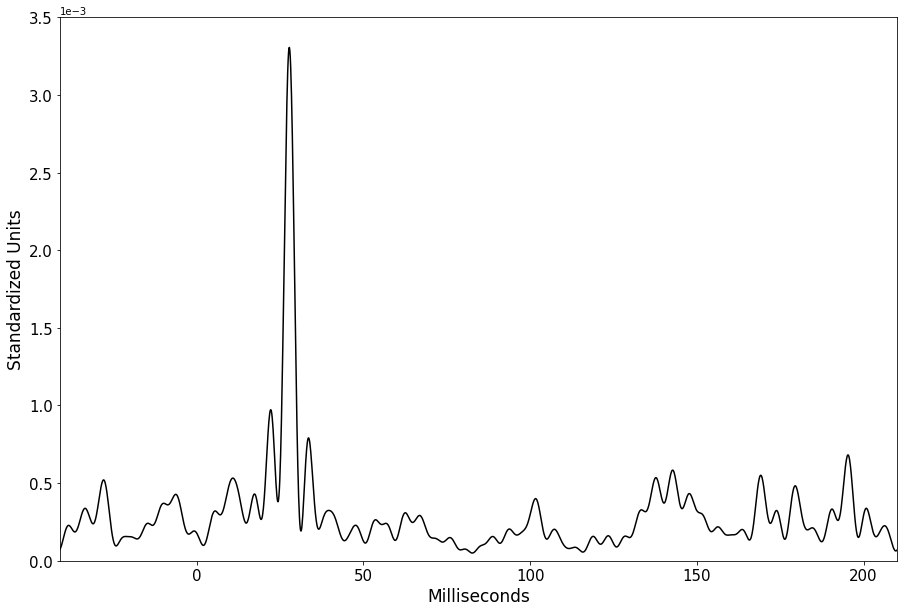

In [7]:
plot_trf(TRF.boostedresult)